In [2]:
import pandas as pd
training_set_labels = pd.read_csv("./training_set_labels.csv", index_col=0)
training_set_labels.shape

(26707, 2)

In [3]:
# Features
training_set_features = pd.read_csv("./training_set_features.csv", index_col=0)
training_set_features.shape

(26707, 35)

In [4]:
test_set_features = pd.read_csv("./test_set_features.csv", index_col=0)
test_set_features.shape

(26708, 35)

In [5]:
training_set_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [6]:
# Searching for null values.
training_set_features.isna().sum() 

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler())
    ])
# The constant on here is ZERO, as we will assume that missing values on 
# health_insurance are those who are not covered.
hardcode_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant")),
        ("scaler", StandardScaler())
    ])
# Indicating to pipeline replace those null values with
# the most frequent value found in that specific row.
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

num_attribs = ["h1n1_concern", "h1n1_knowledge", "behavioral_antiviral_meds", "behavioral_avoidance", "behavioral_face_mask","behavioral_wash_hands","behavioral_large_gatherings", "behavioral_outside_home", "behavioral_touch_face", "doctor_recc_h1n1", "doctor_recc_seasonal", "chronic_med_condition", "child_under_6_months", "health_worker", "opinion_h1n1_vacc_effective", "opinion_h1n1_risk", "opinion_h1n1_sick_from_vacc", "opinion_seas_vacc_effective", "opinion_seas_risk", "opinion_seas_sick_from_vacc"]
cat_attribs = ["age_group", "education", "race", "sex", "income_poverty", "marital_status", "rent_or_own", "employment_status", "hhs_geo_region", "census_msa", "household_adults", "household_children", "employment_industry", "employment_occupation"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("hardcoded", num_pipeline, ["health_insurance"]),
        ("cat", cat_pipeline, cat_attribs),
    ])
total_attribs = num_attribs + ["health_insurance"] + cat_attribs
X_train = preprocess_pipeline.fit_transform(
    training_set_features[total_attribs])
y_train = training_set_labels["h1n1_vaccine"]

# y_train_1 = training_set_labels["h1n1_vaccine"]
# y_train_2 = training_set_labels["seasonal_vaccine"]

In [12]:
from sklearn.linear_model import LogisticRegression

# Please, check the variables applicable to next line:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [13]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)
X_test = preprocess_pipeline.transform(test_set_features[total_attribs])
y_pred = forest_clf.predict(X_test)

In [14]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8340136183196687

In [15]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8356235863912154

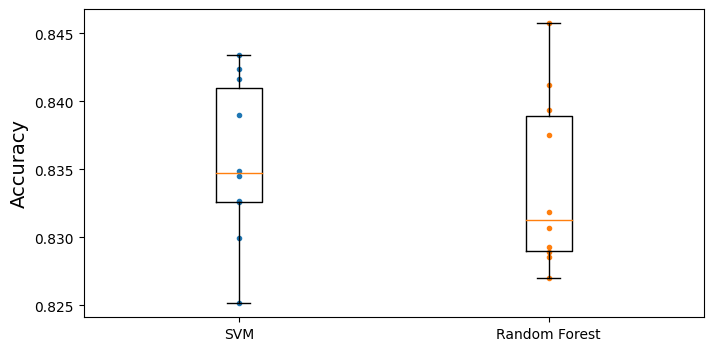

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()